<a href="https://colab.research.google.com/github/BirundhaSIST/house_rent/blob/main/NEWS_CLASSIFICATION_MACHINE_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# **News Category Classification using LSTM**
#**News categories included in this dataset include business; science and technology; entertainment; and health.**

#**Different news articles that refer to the same news item (e.g., several articles about recently released employment statistics) are also categorized together.**

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
path="/content/drive/MyDrive/Colab Notebooks/uci-news-aggregator.csv"
dir=pd.read_csv(path)
dir.describe

<bound method NDFrame.describe of             ID                                              TITLE  \
0            1  Fed official says weak data caused by weather,...   
1            2  Fed's Charles Plosser sees high bar for change...   
2            3  US open: Stocks fall after Fed official hints ...   
3            4  Fed risks falling 'behind the curve', Charles ...   
4            5  Fed's Plosser: Nasty Weather Has Curbed Job Gr...   
...        ...                                                ...   
422414  422933  Surgeons to remove 4-year-old's rib to rebuild...   
422415  422934  Boy to have surgery on esophagus after battery...   
422416  422935  Child who swallowed battery to have reconstruc...   
422417  422936  Phoenix boy undergoes surgery to repair throat...   
422418  422937  Phoenix boy undergoes surgery to repair throat...   

                                                      URL          PUBLISHER  \
0       http://www.latimes.com/business/money/la-fi-mo...

In [13]:
#importing the dataset
#dir = pd.read_csv('../input/news-aggregator-dataset/uci-news-aggregator.csv')
#pd.set_option('display.max_columns', None)
#dir.head()

In [14]:
#**WE HAVE ONLY TWO FEATURES OF USE**

#1. **TITLE**
#2. **CATEGORY**

In [15]:
#creating a new dataset with only relevant features.
ds = dir[['TITLE','CATEGORY']]
#ds=ds.sample(n=42418)
ds.head()
ds.describe

<bound method NDFrame.describe of                                                     TITLE CATEGORY
0       Fed official says weak data caused by weather,...        b
1       Fed's Charles Plosser sees high bar for change...        b
2       US open: Stocks fall after Fed official hints ...        b
3       Fed risks falling 'behind the curve', Charles ...        b
4       Fed's Plosser: Nasty Weather Has Curbed Job Gr...        b
...                                                   ...      ...
422414  Surgeons to remove 4-year-old's rib to rebuild...        m
422415  Boy to have surgery on esophagus after battery...        m
422416  Child who swallowed battery to have reconstruc...        m
422417  Phoenix boy undergoes surgery to repair throat...        m
422418  Phoenix boy undergoes surgery to repair throat...        m

[422419 rows x 2 columns]>

In [16]:
#**HERE YOU CAN SEE THAT ALL CATEGORIES ARE IN ORDER(ALL B's TOGETHER AND SO ON), THEREFORE SHUFFLING THEM FOR OUR CONVENIENCE**


In [17]:
#shuffling rows with the help of sample, here (frac = 1) means return all rows
ds = ds.sample(frac=1).reset_index(drop=True)
ds.head()

,TITLE,CATEGORY
0,Qualcomm slapped with bribery allegations by US,b
1,You are here! Home > SCIENCE and TECHNOLOGY > ...,m
2,More Apps Arrive on Chromecast,t
3,ACA cost cutting means Medicare won't go broke...,m
4,New VR Adventure Game at E3: nDreams Announced,t


In [18]:
#**DATASET IS NOW SHUFFLED**

In [19]:
#checking for null values
ds.isnull().sum()

TITLE       0
CATEGORY    0
dtype: int64

In [20]:

#**NO NULL VALUES FOUND**

<Axes: xlabel='CATEGORY', ylabel='count'>

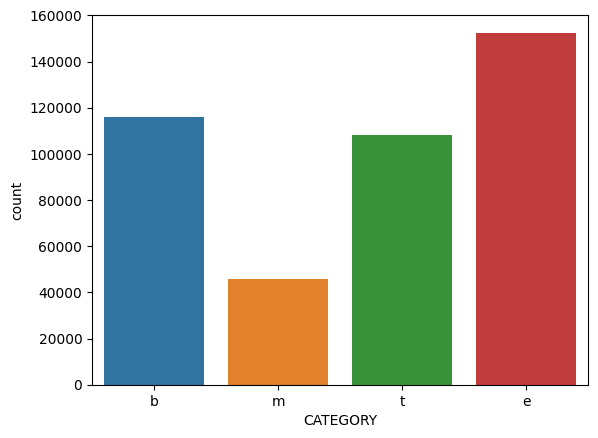

In [21]:
#plotting graph for categories
sns.countplot(x = 'CATEGORY',data = ds)

In [22]:
'''**THERE ARE FOUR TYPES OF CATEGORIES-**
1. **b : business (~115000)**
2. **t : science and technology (~110000)**
3. **e : entertainment (~150000)**
4. **m : health (~40000)**'''


'**THERE ARE FOUR TYPES OF CATEGORIES-**\n1. **b : business (~115000)**\n2. **t : science and technology (~110000)**\n3. **e : entertainment (~150000)**\n4. **m : health (~40000)**'

In [23]:
#**NOW MOVING ONTO CLEANING AND PREPROCESSING OF THE TEXT DATA**
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tensorflow import keras
import os

import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
#cleaning and preprocessing the text

cleaned = []
for i in range(0,len(ds)):

    #removing any other words than (a-z) and (A-Z)
    msg = re.sub('[^a-zA-Z]',' ',ds['TITLE'][i])

    #converting all texts to lower case
    msg = msg.lower()

    #tokenizing
    msg = msg.split()

    #stemming and removing stopwords
    ps = PorterStemmer()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

In [25]:
#cleaned data with no punctuations,stopwords and all texts in lowercase.
cleaned[:5]

['qualcomm slap briberi alleg us',
 'home scienc technolog tire home come',
 'app arriv chromecast',
 'aca cost cut mean medicar go broke till',
 'new vr adventur game e ndream announc']

In [26]:
#taking dictionary size 5000
dict_size = 5000

#one hot encoding
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]

#now for input as an embedding layer length of all rows should be equal therefore applying padding
#this will make size of all rows equal by adding 0 at starting of the shorter rows
#size of each row will be equal to length of longest row.
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 150)
embedded_layer

array([[   0,    0,    0, ..., 2142, 1092, 1246],
       [   0,    0,    0, ..., 1566, 2163, 1977],
       [   0,    0,    0, ..., 2086, 4365, 4309],
       ...,
       [   0,    0,    0, ..., 3996,  201, 3628],
       [   0,    0,    0, ...,  371, 1977, 3605],
       [   0,    0,    0, ..., 2726,  942,  909]], dtype=int32)

In [27]:
#now creating independent and dependent features
x = embedded_layer
y = np.array(ds['CATEGORY'])

In [28]:
#converting categorical values of y using OneHotEncoding
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y,4)

In [29]:
y[:10]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [30]:
#splitting the Dataset into Train and Test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(337935, 150) (337935, 4)
(84484, 150) (84484, 4)


In [31]:
#creating model using LSTM
model = Sequential()

#taking number features as 50
model.add(Embedding(dict_size,50,input_length = len(x[0])))
model.add(Dropout(0.2))

#adding LSTM layers with 100 neurons
model.add(LSTM(100))

#adding output layer
model.add(Dense(4,activation="softmax"))

#compiling the model
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

#summary of model
model.summary()

#training the model
rnn = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, batch_size = 256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           250000    
                                                                 
 dropout (Dropout)           (None, 150, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 310,804
Trainable params: 310,804
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1321/1321 [==============================] - 916s 691ms/step - loss: 0.3846 - accuracy: 0.8578 - val_loss: 0.2846 - val_accuracy: 0.8993
Epoch 2/10
1321/1321 [============

In [33]:
#evaluating our model
model.evaluate(x_test,y_test)

2641/2641 [==============================] - 102s 39ms/step - loss: 0.2370 - accuracy: 0.9214


[0.23700155317783356, 0.9214407205581665]

In [34]:
#making predictions
pred = model.predict(x_test)

#saving index of maximum value of pred in preds (because in pred probabilities will come)
preds = []
for i in range(0,len(pred)):
    preds.append(pred[i].argmax())

#saving index of maximum value of y_test in actual
actual = []
for i in range(0,len(y_test)):
    actual.append(y_test[i].argmax())


2641/2641 [==============================] - 104s 39ms/step


In [35]:
#classification report
from sklearn import metrics
report = metrics.classification_report(actual, preds, target_names = ['b','t','e','m'])
print(report)

              precision    recall  f1-score   support

           b       0.91      0.90      0.90     23238
           t       0.95      0.96      0.95     30640
           e       0.90      0.90      0.90      9110
           m       0.91      0.90      0.91     21496

    accuracy                           0.92     84484
   macro avg       0.91      0.91      0.91     84484
weighted avg       0.92      0.92      0.92     84484



In [63]:
#checking category of a text
#txt = ["US doctor claims ADHD does not exist"]                                          # health
#txt=["Boston's longest-serving mayor has been diagnosed with cancer"]                   # health
#txt=["Keller @ Large: Menino Upbeat And Determined To Beat Cancer"]                     # health
#txt= ["Five things you need to know today, and is this the best Amazon.com sale ever?"] # business
#txt= ["No chance of EU-US trade deal in 2014"]                                          # business
#txt=["Carl Icahn: Donahoe Cost eBay Investors More Than $4B"]                           # business
#txt=["In Hollywood's Bible epic revival, Darren Aronofsky's 'Noah' finds rough seas"]   # entertainment
#txt=["Rick Ross' 'Mastermind' outfoxes Pharrell Williams' 'GIRL' on Billboard 200"]     # entertainment
#txt=["On the Charts: Pharrell, Rick Ross Post Big Opening Weeks"]                       # entertainment
#txt=["Google has plans to support wearable technology"]                                 # science
#txt=["Google Glass Price: Will Consumer Wishes Dictate The Cost Of The Device  ..."]    # science
txt=["It's looking less likely that Apple will develop an iTelevision"]                 # science

#cleaning and preprocessing the text
cleaned = []
for i in range(0,len(txt)):
    msg = re.sub('[^a-zA-Z]',' ',txt[i])
    msg = msg.lower()
    msg = msg.split()
    ps = PorterStemmer()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

#one hot encoding and embedding layer
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 150)
embedded_layer

#prediction
pred = model.predict(embedded_layer)
#cat = ['Business','Science','Entertainment','Health']
cat = ['Business','Entertainment','Health','Science']
f=cat[np.argmax(pred)]
print(pred, cat[np.argmax(pred)])



1/1 [==============================] - 0s 57ms/step
[[0.03052416 0.03282339 0.0107102  0.92594224]] Science


In [64]:
print(f)

if cat[np.argmax(pred)]== 'Entertainment':
  c='e'
elif cat[np.argmax(pred)]== 'Science':
  c='t'
elif cat[np.argmax(pred)]== 'Health':
  c='m'
else:
  c='b'

ds_new=ds[ds['CATEGORY']==c]
print(ds_new)

Science
                                                    TITLE CATEGORY
2                          More Apps Arrive on Chromecast        t
4          New VR Adventure Game at E3: nDreams Announced        t
9                       3.3 Million More GM Cars Recalled        t
20                          Gas prices rise about 2 cents        t
28               Tablet Shipments To Overtake PCs In 2015        t
...                                                   ...      ...
422402  Tweetdeck has an XSS flaw. Here's what you sho...        t
422403  Sense 6.0 Coming To HTC One In May-June, Accor...        t
422406  Google I/O: APIs and Cloud Platform Tools for ...        t
422415  DirecTV's new Sunday Ticket streaming service ...        t
422418  US Regions With Highest Air Pollution Are in C...        t

[108344 rows x 2 columns]
